In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.inspection import permutation_importance

## Import Data

In [2]:
datafile = 'OnlineNewsPopularity.csv'
df = pd.read_csv(datafile)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


## Class Labels - 4 Classes

In [3]:
# N=4
df['class_N4'] = 0
df.loc[(df[' shares']>=1050) & (df[' shares']<2350), 'class_N4'] = 1
df.loc[(df[' shares']>=2350) & (df[' shares']<7550), 'class_N4'] = 2
df.loc[df[' shares']>=7550, 'class_N4'] = 3

## Feature Engineering

In [4]:
df.columns = df.columns.str.replace(' ', '')
df.loc[:,'No_word'] = df.n_tokens_content.apply(lambda x: 1 if x==0 else 0)
topic_list = list(df.columns[df.columns.str.contains('LDA')])
all_below_point3 = list(df[topic_list][df[topic_list]<0.3].dropna().index)
df.loc[all_below_point3, 'all_topic'] = 1
df ['all_topic']= df['all_topic'].fillna(0)

## Data Cleaning and Data Transformation

In [5]:
#outlier (>1) in var “n_unique_tokens”, “n_non_stop_words”, and “n_non_stop_unique_tokens”, 
#which might be due to typing error. We will remove that observation.
col_list = [4,5,6]
for col in col_list:
    print(df.columns[col])
    df = df[df[df.columns[col]]<1]

n_unique_tokens
n_non_stop_words
n_non_stop_unique_tokens


In [6]:
#Missing values are very troubling in this data set because they are coded as 0. 
#So you have to judge if the 0 are missing or real data. By check the distributions, 
#we found around 3000 observations with missing values in 9 different variables. 
#We will remove all cases with missing values.
col_list = [11,20,44,45,46,48,49,50,53]
for col in col_list:
    print(df.columns[col])
    df = df[df[df.columns[col]]!=0]

average_token_length
kw_max_min
global_subjectivity
global_sentiment_polarity
global_rate_positive_words
rate_positive_words
rate_negative_words
avg_positive_polarity
avg_negative_polarity


In [7]:
#treat skewed data. 
#for those variables with all values bigger than 0, use log
#and other variable with 0, use square root.

col_list = [3,7,8,9,10,22,26,27,28,29,30,39,40,41,42,43,47,60] ######
for col in col_list:
    print(df.columns[col])
    if np.min(df[df.columns[col]]) > 0:
        col_name = 'log_'+df.columns[col]
        df[df.columns[col]] = np.log(df[df.columns[col]])
    else:
        col_name = 'sqrt_'+df.columns[col]
        df[df.columns[col]] = np.sqrt(df[df.columns[col]])   
    if df.columns[col] != ' shares':
        df.rename(columns={df.columns[col]:col_name}, inplace=True)


n_tokens_content
num_hrefs
num_self_hrefs
num_imgs
num_videos
kw_min_max
kw_max_avg
kw_avg_avg
self_reference_min_shares
self_reference_max_shares
self_reference_avg_sharess
LDA_00
LDA_01
LDA_02
LDA_03
LDA_04
global_rate_negative_words
shares


## Logistic Regression Model
### First Round Optimization

In [8]:
target = 'class_N4'



features = ['sqrt_num_hrefs',  
            'sqrt_num_self_hrefs', 
            'average_token_length', 
            'log_kw_max_avg', 
            'log_kw_avg_avg', 
            'weekday_is_tuesday', 
            'weekday_is_friday',  
            'is_weekend', 
            'log_LDA_00', 
            'log_LDA_01',
            'log_LDA_02', 
            'log_LDA_03', 
            'log_LDA_04', 
            'global_subjectivity', 
            'global_sentiment_polarity', 
            'global_rate_positive_words',
            'log_global_rate_negative_words', 
            'rate_positive_words', 
            'avg_positive_polarity', 
            'avg_negative_polarity', 
            'title_subjectivity', 
            'title_sentiment_polarity', 
            
            'all_topic', 
            'No_word',
            
            'n_unique_tokens', 
            'sqrt_self_reference_min_shares', 
           ]

seed = 2021
test_size = 0.2 

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

df_X = df[features]
df_y = df[target]

X_train, X_test, y_train, y_test = train_test_split(df_X,
                                                    df_y,
                                                    test_size=test_size,
                                                    random_state=seed,
                                                    stratify=df_y)

kf = StratifiedKFold(n_splits=5, shuffle=False)

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression(l1_ratio=0.1,penalty='elasticnet',solver='saga')
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))


param = {'l1_ratio':[0,0.001,0.01,0.1,1]}
lr = LogisticRegression(penalty='elasticnet',solver='saga')
best_lr=GridSearchCV(estimator=lr, param_grid=param, cv=10)
best_lr.fit(X_train, y_train)
print('best estimator',best_lr.best_estimator_)

0.43864364726558464
0.44314266023432114
best estimator LogisticRegression(l1_ratio=0.01, penalty='elasticnet', solver='saga')


Text(0.5, 1.0, 'Logistic Regaression Features (averaged over store predictions)')

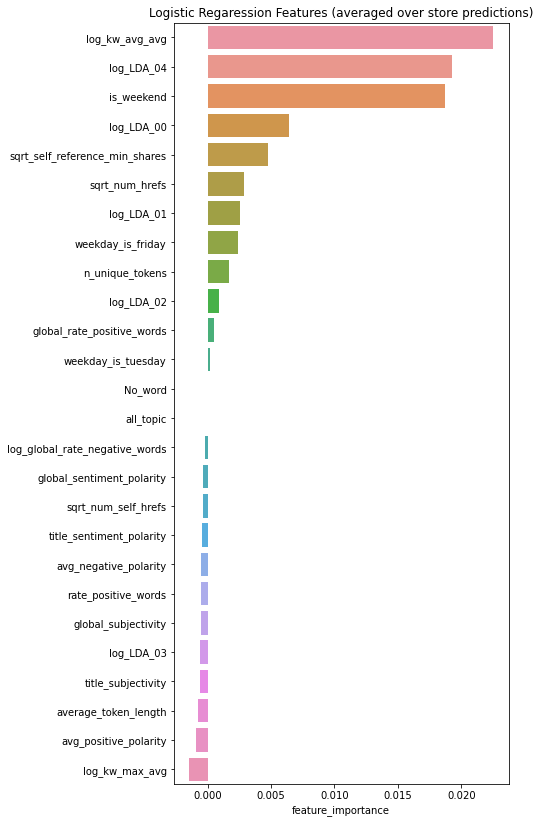

In [35]:
lr=LogisticRegression(l1_ratio=0.01, penalty='elasticnet', solver='saga')
lr.fit(X_train, y_train)
plt.figure(figsize=(6, 14))

imp_lr = permutation_importance(lr, X=X_train, y=y_train, scoring='accuracy',random_state=seed).importances_mean
feature_importance_df=pd.DataFrame(index=df_X.columns,data=imp_lr,columns=['feature_importance'])
feature_importance_df=feature_importance_df.sort_values('feature_importance',ascending=False)

sns.barplot(x="feature_importance", y=feature_importance_df.index, data=feature_importance_df)
plt.title('Logistic Regaression Features (averaged over store predictions)')



In [24]:
feature_importance_df['features']=abs(feature_importance_df['feature_importance'])
feature_importance_df=feature_importance_df.sort_values('features',ascending=False)
feature_importance_df

,feature_importance,features
log_kw_avg_avg,2.250939e-02,2.250939e-02
log_LDA_04,1.924257e-02,1.924257e-02
is_weekend,1.870499e-02,1.870499e-02
log_LDA_00,6.402702e-03,6.402702e-03
sqrt_self_reference_min_shares,4.789965e-03,4.789965e-03
sqrt_num_hrefs,2.894655e-03,2.894655e-03
log_LDA_01,2.584514e-03,2.584514e-03
weekday_is_friday,2.377753e-03,2.377753e-03
n_unique_tokens,1.667873e-03,1.667873e-03
log_kw_max_avg,-1.468004e-03,1.468004e-03


In [25]:

feature_0 = feature_importance_df.index[0]

index=[list(df_X.columns).index(feature_0)]

lr.fit(X_train[:,index], y_train)


score_0 = accuracy_score(y_test, lr.predict(X_test[:,index]))

features = [feature_0]
scores = [score_0]

for feature in feature_importance_df.index[1:]:
    index_temp=[list(df_X.columns).index(feature)]
#     features_temp = features.copy()
    index_temp=index+index_temp
#     print(index_temp)
    
    lr.fit(X_train[:,index_temp], y_train)
    score = accuracy_score(y_test, lr.predict(X_test[:,index_temp]))
    if score > max(scores):
        features.append(feature)
        scores.append(score)
        index=index_temp
print('number of features: ', len(features))
print(features)
print(scores)
print(index)


number of features:  14
['log_kw_avg_avg', 'log_LDA_04', 'is_weekend', 'log_LDA_00', 'sqrt_self_reference_min_shares', 'sqrt_num_hrefs', 'log_LDA_01', 'weekday_is_friday', 'avg_positive_polarity', 'log_LDA_02', 'average_token_length', 'title_subjectivity', 'title_sentiment_polarity', 'weekday_is_tuesday']
[0.3940730530668504, 0.4046864231564438, 0.42095106822880773, 0.4268780151619573, 0.4304617505168849, 0.43818056512749826, 0.44024810475534115, 0.4405237767057202, 0.44079944865609927, 0.442315644383184, 0.44383184011026877, 0.4445210199862164, 0.44548587181254307, 0.4461750516884907]
[4, 12, 7, 8, 25, 0, 9, 6, 18, 10, 2, 20, 21, 5]


Text(0, 0.5, 'accuracy score')

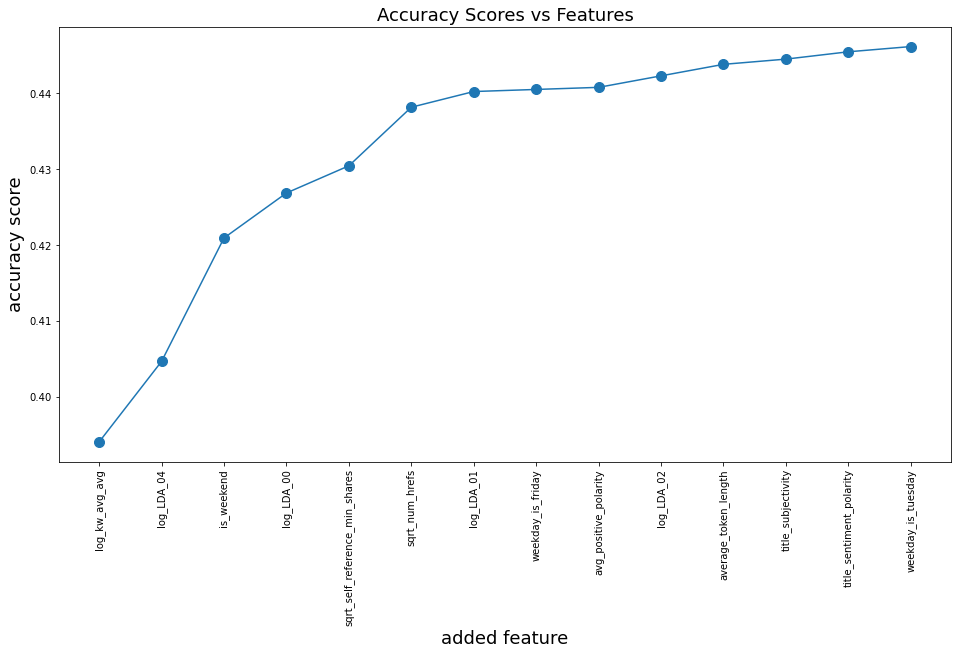

In [26]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(range(len(features)), scores, marker = '.', markersize = 20)
ax.set_title("Accuracy Scores vs Features", fontsize=18)
ax.set_xticks(range(len(features)))
ax.set_xticklabels(features,rotation=90)
ax.set_xlabel("added feature", fontsize=18)
ax.set_ylabel("accuracy score", fontsize=18)

In [27]:
lr_adjust = LogisticRegression(l1_ratio=0.1,penalty='elasticnet',solver='saga')
lr_adjust.fit(X_train[:,index], y_train)
print(lr_adjust.score(X_train[:,index], y_train))
print(lr_adjust.score(X_test[:,index], y_test))


param = {'l1_ratio':[0,0.001,0.01,0.1,1]}
lr_adjust = LogisticRegression(penalty='elasticnet',solver='saga',random_state=seed)
best_lr_adjust=GridSearchCV(estimator=lr, param_grid=param, cv=10)
best_lr_adjust.fit(X_train[:,index], y_train)
print('best estimator',best_lr.best_estimator_)

0.43736862055894415
0.44645072363886973
best estimator LogisticRegression(l1_ratio=0, penalty='elasticnet', solver='saga')


Text(0.5, 1.0, 'Logistic Regaression Features (averaged over store predictions)')

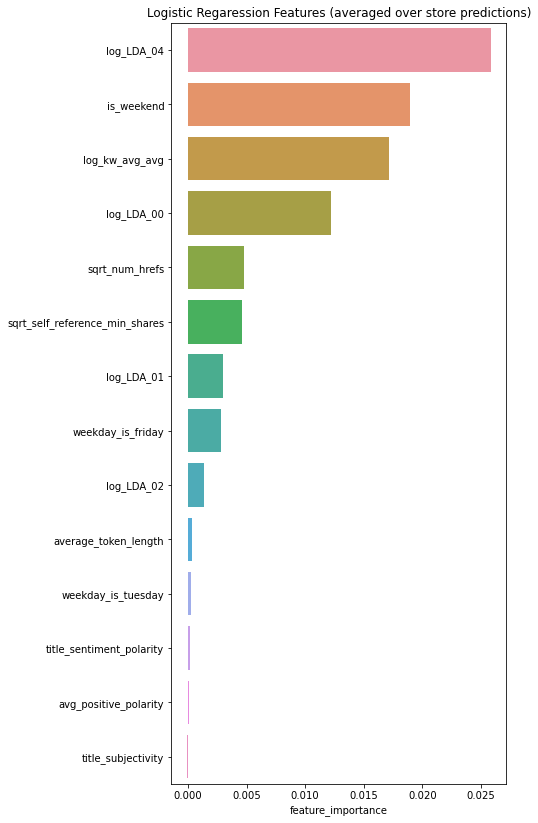

In [34]:
lr_adjust= LogisticRegression(l1_ratio=0, penalty='elasticnet', solver='saga',random_state=seed)
lr_adjust.fit(X_train[:,index], y_train)
plt.figure(figsize=(6, 14))

imp_lr = permutation_importance(lr_adjust, X=X_train[:,index], y=y_train, scoring='accuracy',random_state=seed).importances_mean
feature_importance_df=pd.DataFrame(index=df_X.columns[index],data=imp_lr,columns=['feature_importance'])
feature_importance_df=feature_importance_df.sort_values('feature_importance',ascending=False)

sns.barplot(x="feature_importance", y=feature_importance_df.index, data=feature_importance_df)
plt.title('Logistic Regaression Features (averaged over store predictions)')

In [33]:
y_pred=lr_adjust.predict(X_test[:,index])
lr_report = classification_report(y_test, y_pred)
auc = roc_auc_score(y_test, lr_adjust.predict_proba(X_test[:,index]), multi_class='ovr')
accuracy = accuracy_score(y_test, y_pred)
print(lr_report)
print('roc_auc_score',auc)
print('accuracy_score',accuracy)

              precision    recall  f1-score   support

           0       0.50      0.49      0.49      2252
           1       0.42      0.71      0.53      2829
           2       0.42      0.07      0.12      1599
           3       0.36      0.02      0.04       575

    accuracy                           0.45      7255
   macro avg       0.43      0.32      0.30      7255
weighted avg       0.44      0.45      0.39      7255

roc_auc_score 0.6511766823644244
accuracy_score 0.4460372157133012
